In [1]:
import os
import zipfile
import pickle
import h5py
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

In [2]:
import scipy as sp
import scipy.ndimage as spi
import numpy as np
import pandas as pd
import PIL

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1 for meningioma, 2 for glioma, 3 for pituitary tumor

In [4]:
image_size = (256, 256)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/dataset/BrainTumor",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size= BATCH_SIZE,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/dataset/BrainTumor",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=BATCH_SIZE,
)

Found 3064 files belonging to 3 classes.
Using 2452 files for training.
Found 3064 files belonging to 3 classes.
Using 612 files for validation.


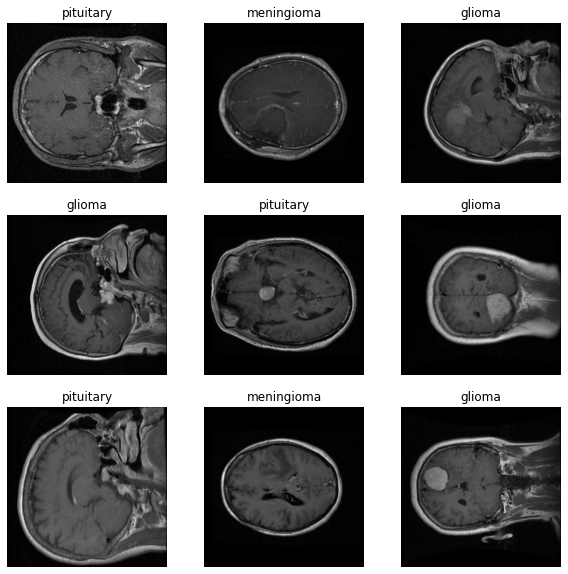

In [5]:
class_names = [ 'meningioma', 'glioma','pituitary']
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[int(labels[i])])
      plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

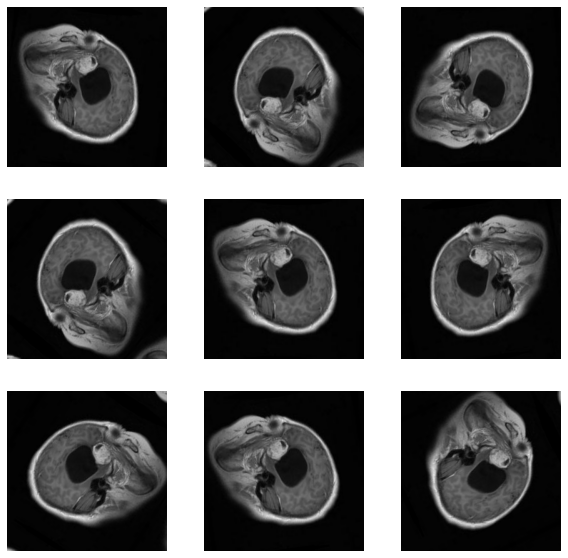

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [10]:
train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

In [11]:
image_shape = image_size + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=image_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 2048)


In [13]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [15]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [16]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [17]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2048,activation='relu')(x)
x = tf.keras.activations.sigmoid(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2048,activation='relu')(x)
x = tf.keras.activations.sigmoid(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

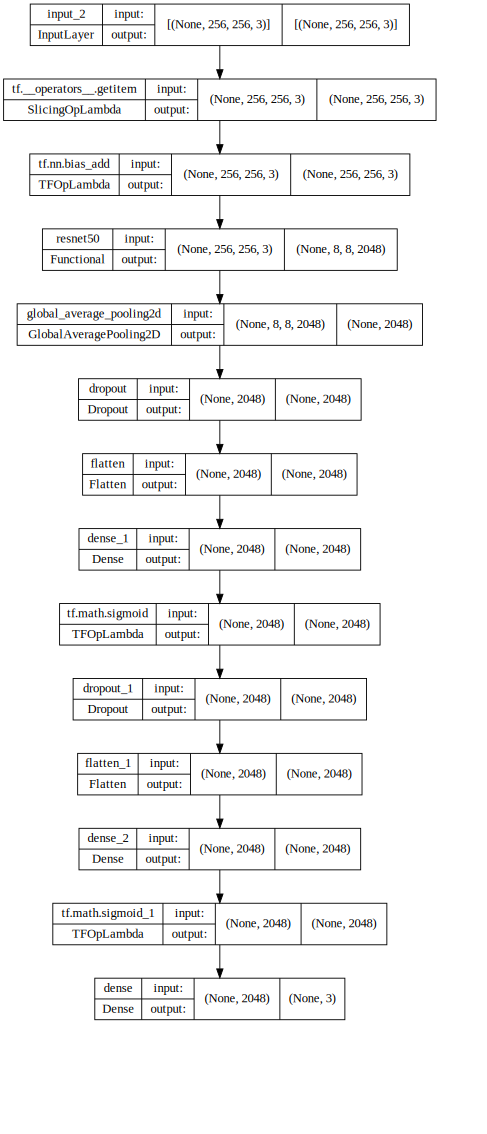

In [18]:
SVG(model_to_dot(model,
                 show_shapes= True,
                 show_layer_names=True,
                 dpi=65).create(prog='dot', format='svg'))

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [20]:
BASE_LEARNING_RATE = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = BASE_LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [21]:
len(model.trainable_variables)

6

In [22]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

16/16 [==============================] - 50s 1s/step - loss: 1.0668 - accuracy: 0.4566
initial loss: 1.07
initial accuracy: 0.46


In [23]:
%%time
history = model.fit(train_ds,
                         epochs=30,
                         validation_data=val_ds,
                         shuffle=True
                        )

Epoch 1/30
77/77 [==============================] - 182s 2s/step - loss: 0.9890 - accuracy: 0.5245 - val_loss: 0.8268 - val_accuracy: 0.6343
Epoch 2/30
77/77 [==============================] - 43s 557ms/step - loss: 0.7567 - accuracy: 0.6949 - val_loss: 0.6092 - val_accuracy: 0.7459
Epoch 3/30
77/77 [==============================] - 57s 735ms/step - loss: 0.5875 - accuracy: 0.7643 - val_loss: 0.5057 - val_accuracy: 0.8058
Epoch 4/30
77/77 [==============================] - 67s 863ms/step - loss: 0.4996 - accuracy: 0.7949 - val_loss: 0.4476 - val_accuracy: 0.7996
Epoch 5/30
77/77 [==============================] - 43s 557ms/step - loss: 0.4720 - accuracy: 0.8030 - val_loss: 0.4479 - val_accuracy: 0.8202
Epoch 6/30
77/77 [==============================] - 43s 551ms/step - loss: 0.4362 - accuracy: 0.8173 - val_loss: 0.3857 - val_accuracy: 0.8430
Epoch 7/30
77/77 [==============================] - 44s 562ms/step - loss: 0.4238 - accuracy: 0.8316 - val_loss: 0.3687 - val_accuracy: 0.8430
E

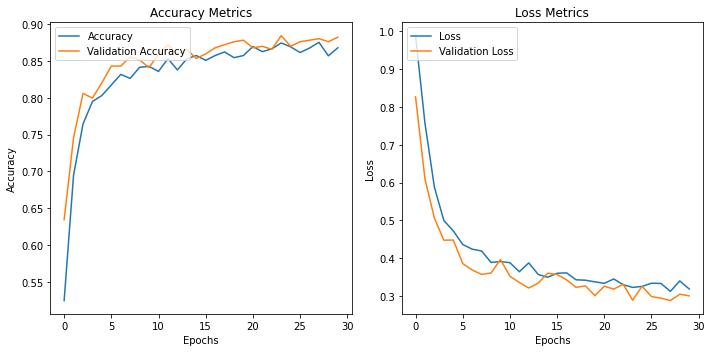

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
EPOCHS = 30
epochs_range = range(0, EPOCHS)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = axes[0]
ax2 = axes[1]
ax1 = plt.subplot(1,2,1)
      
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy Metrics")
ax1.plot(epochs_range, acc)
ax1.plot(epochs_range, val_acc)
ax1.legend(["Accuracy", "Validation Accuracy"], loc ="upper left")
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(0, EPOCHS)

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss Metrics")
ax2.plot(epochs_range, loss)
ax2.plot(epochs_range, val_loss)
ax2.legend(["Loss", "Validation Loss"], loc ="upper left")

fig.tight_layout()

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [26]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Colab Notebooks/dataset/BrainTumor/meningioma/114.jpg",
     target_size=image_size
)
img2 = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Colab Notebooks/dataset/BrainTumor/glioma/1850.jpg",
     target_size=image_size
)
img3 = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Colab Notebooks/dataset/yes/y1000.jpg",
    target_size=image_size
)
img4 = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Colab Notebooks/dataset/yes/y1006.jpg",
    target_size=image_size
)
img5 = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Colab Notebooks/dataset/yes/y548.jpg",
    target_size=image_size
)
img6 = keras.preprocessing.image.load_img(
      "/content/drive/MyDrive/Colab Notebooks/dataset/yes/y60.jpg",
      target_size=image_size
)
img7 = keras.preprocessing.image.load_img(
      "/content/drive/MyDrive/Colab Notebooks/dataset/yes/y148.jpg", 
      target_size=image_size
)
image_array = [img, img2, img3, img4, img5, img6,img7]
for image in image_array :

    img_array = keras.preprocessing.image.img_to_array(image)
    # Create batch axis
    img_array = tf.expand_dims(img_array, 0)  
    predictions = model.predict(img_array)

    score = tf.nn.softmax(predictions[0])

    print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )
  




This image most likely belongs to glioma with a 99.20 percent confidence.
This image most likely belongs to meningioma with a 99.95 percent confidence.
This image most likely belongs to pituitary with a 67.15 percent confidence.
This image most likely belongs to pituitary with a 65.15 percent confidence.
This image most likely belongs to pituitary with a 86.00 percent confidence.
This image most likely belongs to pituitary with a 75.40 percent confidence.
This image most likely belongs to meningioma with a 76.49 percent confidence.


In [27]:
%cd /content/drive/MyDrive/Colab Notebooks/
model.save('model_final_multi-classification.h5')
    

/content/drive/MyDrive/Colab Notebooks


In [28]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 2s 266ms/step - loss: 0.2206 - accuracy: 0.9219
Test accuracy : 0.921875


In [29]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test_ds.as_numpy_iterator():
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-3):
        pred = np.argmax(predictions[n:n+3]) #Returns the index of the largest element in the selected subarray
        n+=3
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[0 0 0 0 1 0 1 2 1 0 1 2 0 0 2 1 2 0 2 0 0 1 1 2 2 1 2 1 1 0 2 2 0 2 0 0 0
 0 2 2 0 2 0 2 0 2 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 2 0 1 0 2 2 2 1 2 0 2 0 0
 2 1 2 2 1 2 0 0 2 2 1 0 0 0 1 0 0 1 1 1 0 1 2 2 1 2 0 2 2 0 1 0 2 0 2 2 2
 1 0 2 2 0 1 2 0 1 2 0 0 0 0 2 0 1]
[1 0 0 0 1 0 1 2 1 0 0 2 0 0 2 1 2 0 2 0 0 2 1 2 2 0 2 2 0 0 2 2 0 2 0 0 0
 0 2 2 0 2 0 2 1 2 0 0 0 0 0 0 0 1 0 0 0 2 1 0 2 2 0 1 0 2 2 2 1 2 0 2 0 0
 2 1 2 2 0 2 0 0 2 2 1 0 0 0 1 0 0 1 0 1 1 1 2 2 1 2 0 2 2 0 1 0 2 0 2 2 2
 1 0 2 2 0 1 1 0 1 2 0 0 0 1 2 0 1]


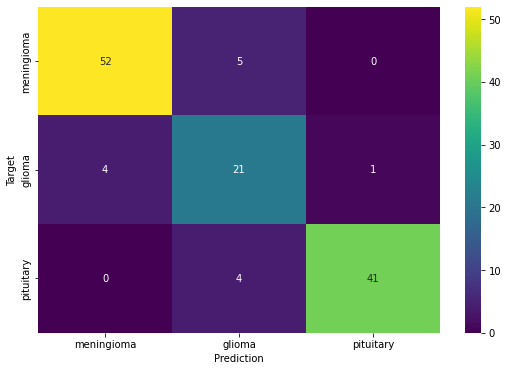

In [30]:

arr = confusion_matrix(labels_entire, pred_entire)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

In [31]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels_entire, pred_entire, pos_label=2)
metrics.auc(fpr, tpr)
 

0.9795180722891565

In [32]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
print(classification_report(labels_entire, pred_entire, target_names=class_names))

              precision    recall  f1-score   support

  meningioma       0.93      0.91      0.92        57
      glioma       0.70      0.81      0.75        26
   pituitary       0.98      0.91      0.94        45

    accuracy                           0.89       128
   macro avg       0.87      0.88      0.87       128
weighted avg       0.90      0.89      0.89       128



In [33]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
print(f"Accuracy: {round(accuracy_score(labels_entire, pred_entire), 2)}") 


Accuracy: 0.89
